In [1]:
import numpy as np
import astropy as ast
import matplotlib.pyplot as plt

from astropy import units as u

In [2]:
def get_phi(vector: np.ndarray) -> float:
    """Return the azimuthal angle of vector (in conventional spherical coordinates).
    """
    
    if vector[0] > 0:
        return np.arctan(vector[1] / vector[0])
    elif vector[0] < 0 :
        return np.arctan(vector[1] / vector[0]) + np.pi
    else:
        if vector[1] > 0:
            return np.pi / 2
        elif vector[1] < 0:
            return -np.pi / 2
        else:
            return 0

In [3]:
def get_theta(vector: np.ndarray) -> float:
    """Return the polar angle of vector (in conventional spherical coordinates).
    """
    
    rho = np.sqrt(np.sum(vector ** 2))
    
    if rho != 0:
        return np.arccos(vector[2] / rho)
    else:
        return np.pi / 2

In [4]:
def build_triple_rotation_matrix(ref_r: np.ndarray, ref_L: np.ndarray) -> np.ndarray:
    """Return a matrix object to transform vectors to from an original coordinate system
    to a coordinate system where (x = ref_r, y = 0, z = 0) and z points along ref_L.
    """
    
    # get the angles of spherical coordinates of ref_r
    phi = get_phi(ref_r)
    theta = get_theta(ref_r)
    
    # rotation 1 rotates around z-axis 
    rotation_1 = np.zeros([3, 3])
    
    rotation_1[0][0] = np.cos(phi)
    rotation_1[0][1] = np.sin(phi)
    rotation_1[1][0] = -np.sin(phi)
    rotation_1[1][1] = np.cos(phi)
    rotation_1[2][2] = 1
    
    # rotation 2 rotates around new y-axis
    rotation_2 = np.zeros([3, 3])
    
    rotation_2[0][0] = np.sin(theta)
    rotation_2[0][2] = np.cos(theta)
    rotation_2[2][0] = -np.cos(theta)
    rotation_2[2][2] = np.sin(theta)
    rotation_2[1][1] = 1
    
    double_rotation = rotation_2 @ rotation_1
    
    # rotate ref_L by rotation_1 then rotation_2
    interm_L = double_rotation @ ref_L
    
    # rearrange components of interm_L to get azimuthal angle w.r.t. x instead of z
    pseudo_L = np.array([
        interm_L[1],
        interm_L[2],
        interm_L[0]
    ])
    
    pseudo_phi = get_phi(pseudo_L)
    
    # rotation_3 rotates around new x-axis
    rotation_3 = np.zeros([3, 3])
    
    rotation_3[0][0] = 1
    rotation_3[1][1] = np.sin(pseudo_phi)
    rotation_3[1][2] = -np.cos(pseudo_phi)
    rotation_3[2][1] = np.cos(pseudo_phi)
    rotation_3[2][2] = np.sin(pseudo_phi)
    
    return rotation_3 @ double_rotation

In [5]:
def n_sigma_clipping(max_longitude_rad: float, longitudes_rad: np.ndarray, values: np.ndarray,
                     w: float, max_value: float, min_value: float, n: float) -> tuple:
    """Return the list of longitudes (in degrees) between -max_longitude_rad and max_longitude_rad where 
    there are stars within +/- w degrees and their angular moment is between min_value and max_value and the 
    list of average angular momentum in each of those ranges and the list of standard deviations in angular 
    momentum in each of those ranges, given a star cluster's longitudes_rad and values, both recalculated after 
    excluding values greater than n original standard deviations.
    """

    degs = []
    avg_delta_Lz = []
    std_delta_Lz = []

    for deg in np.arange(-max_longitude_rad * u.rad.to(u.deg), max_longitude_rad * u.rad.to(u.deg) + 1):

        delta_Lz_list = []

        for star in range(len(longitudes_rad)):

            if deg - w <= longitudes_rad[star] * u.rad.to(u.deg) < deg + w\
            and min_value <= values[star] <= max_value:
                delta_Lz_list.append(values[star])

        if delta_Lz_list != []:

            mean = np.mean(delta_Lz_list)
            sigma = np.std(delta_Lz_list)
            
            new_delta_Lz_list = []
            
            for v in delta_Lz_list:
                if abs(v - mean) <= n * sigma:
                    new_delta_Lz_list.append(v)
                    
            if new_delta_Lz_list != []:
                degs.append(deg)
                avg_delta_Lz.append(np.mean(new_delta_Lz_list))
                std_delta_Lz.append(np.std(new_delta_Lz_list))
            
    return(np.array(degs), avg_delta_Lz, std_delta_Lz)

In [6]:
# begin copied from previous notebook

In [7]:
dir = '/data/vxtest/514d'

d = {'1330': {}, '1300': {}, '1200': {}, '1100': {}, '1000': {}}

In [8]:
for t in d:

    filename = dir + '/snapshot_' + t
    haloname = dir + '/h' + t + '.z0.000.AHF_halos'

    dh = np.loadtxt(haloname)
    d[t]['xh'] = dh[:,5]
    d[t]['yh'] = dh[:,6]
    d[t]['zh'] = dh[:,7]
    d[t]['vxh'] = dh[:,8]
    d[t]['vyh'] = dh[:,9]
    d[t]['vzh'] = dh[:,10]

    hd = np.fromfile(filename,dtype='int32',count=7)
    d[t]['nd'] = hd[2]
    d[t]['ns'] = hd[5]
    d[t]['nc'] = hd[3]
    #head = np.fromfile(filename,dtype='double',count=7,offset=4+6*4)
    #time=head[6]

    start_d = 0
    start_c = d[t]['nd']
    start_s = d[t]['nd'] + d[t]['nc']
    block = d[t]['nd'] + d[t]['nc'] + d[t]['ns']

    skipx = 256 + 3*4 + start_c*3*8
    skipv = 256 + 5*4 + (block*3 + start_c*3)*8
    skipi = 256 + 7*4 + block*3*2*8 + start_c*4
    d[t]['rc'] = np.fromfile(filename, dtype='double', count=3*d[t]['nc'], offset=skipx)
    d[t]['vc'] = np.fromfile(filename, dtype='double', count=3*d[t]['nc'], offset=skipv)

    d[t]['idc'] = np.fromfile(filename, dtype='uint32', count=d[t]['nc'], offset=skipi)
    d[t]['jxc'] = d[t]['rc'][0::3] - d[t]['xh'][0]
    d[t]['jyc'] = d[t]['rc'][1::3] - d[t]['yh'][0]
    d[t]['jzc'] = d[t]['rc'][2::3] - d[t]['zh'][0]

    d[t]['jvxc'] = d[t]['vc'][0::3] - d[t]['vxh'][0]
    d[t]['jvyc'] = d[t]['vc'][1::3] - d[t]['vyh'][0]
    d[t]['jvzc'] = d[t]['vc'][2::3] - d[t]['vzh'][0]

    d[t]['idc'] -= d[t]['nd']
    ki = np.zeros(d[t]['nc'], dtype='int32')

    for j in range(d[t]['nc']):
        ix = d[t]['idc'][j]
        ki[ix] = j

    d[t]['xc'] = d[t]['jxc'][ki]
    d[t]['yc'] = d[t]['jyc'][ki]
    d[t]['zc'] = d[t]['jzc'][ki]

    d[t]['vxc'] = d[t]['jvxc'][ki]
    d[t]['vyc'] = d[t]['jvyc'][ki]
    d[t]['vzc'] = d[t]['jvzc'][ki]

    skipx = 256 + 3*4 + start_s*3*8
    skipv = 256 + 5*4 + block*3*8 + start_s*3*8 #skip over r, and dm+c v's
    skipi = 256 + 7*4 + block*3*2*8 + start_s*4 #skip over r and v and dm+c id
    skipc = 256 + 9*4 + block*(2*3*8+4) + start_s*4 #skip over r, v and id and dm+c ic

    d[t]['rs'] = np.fromfile(filename, dtype='double', count=3*d[t]['ns'], offset=skipx)
    d[t]['vs'] = np.fromfile(filename, dtype='double', count=3*d[t]['ns'], offset=skipv)
    d[t]['ics'] = np.fromfile(filename, dtype='uint32', count=d[t]['ns'], offset=skipc)

    d[t]['xs'] = d[t]['rs'][0::3] - d[t]['xh'][0]
    d[t]['ys'] = d[t]['rs'][1::3] - d[t]['yh'][0]
    d[t]['zs'] = d[t]['rs'][2::3] - d[t]['zh'][0]
    d[t]['vxs'] = d[t]['vs'][0::3] - d[t]['vxh'][0]
    d[t]['vys'] = d[t]['vs'][1::3] - d[t]['vyh'][0]
    d[t]['vzs'] = d[t]['vs'][2::3] - d[t]['vzh'][0]

    # distance from centre of galaxy
    d[t]['ds'] = np.sqrt(d[t]['xs'] ** 2 + d[t]['ys'] ** 2 + d[t]['zs'] ** 2)

In [9]:
# end copied from previous notebook

In [10]:
zoom = 4
dg = 1/90

lon_max = np.pi / zoom
lat_max = np.pi / 3 / zoom

ng_lon = int(2 * lon_max / dg + 1) 
ng_lat = int(2 * lat_max / dg + 1)

lon = np.linspace(-lon_max, lon_max, ng_lon + 1) 
lat = np.linspace(-lat_max, lat_max, ng_lat + 1) 
lon_v, lat_v = np.meshgrid(lon, lat)

In [11]:
lon_range_deg = np.arange(-40, 50, 10)
lon_range_deg_str = []

for deg in lon_range_deg:
    s = str(deg) + r'$^{\circ}$'
    lon_range_deg_str.append(s)
    
    
lat_range_deg = np.arange(-15, 20, 5)
lat_range_deg_str = []

for deg in lat_range_deg:
    s = str(deg) + r'$^{\circ}$'
    lat_range_deg_str.append(s)

In [12]:
# Zoomed in

In [13]:
with_tail = [0, 5, 6, 7, 9, 11, 13, 14, 22, 26, 27, 28, 31, 33, 37, 40, 45, 46, 47, 52, 58, 59, 62]

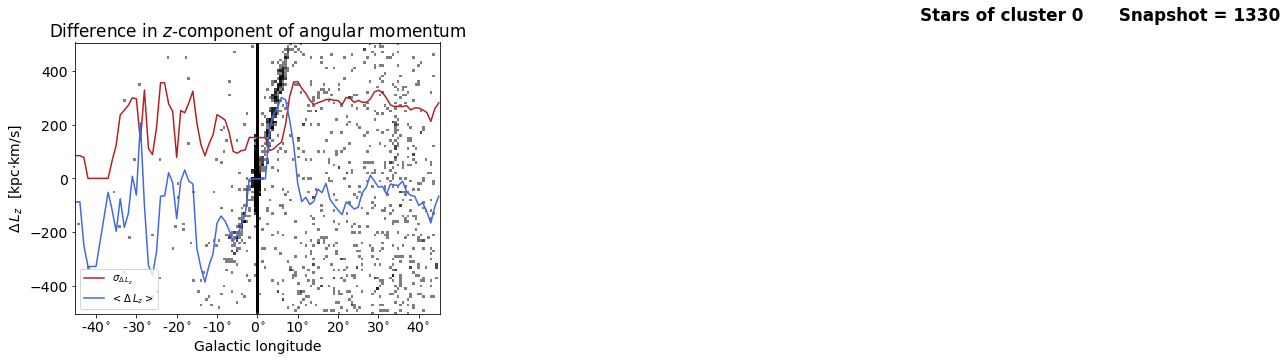

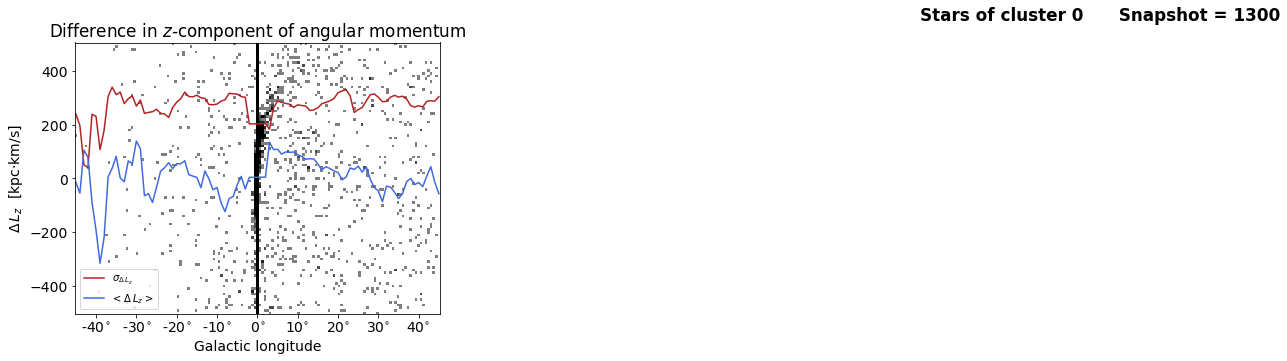

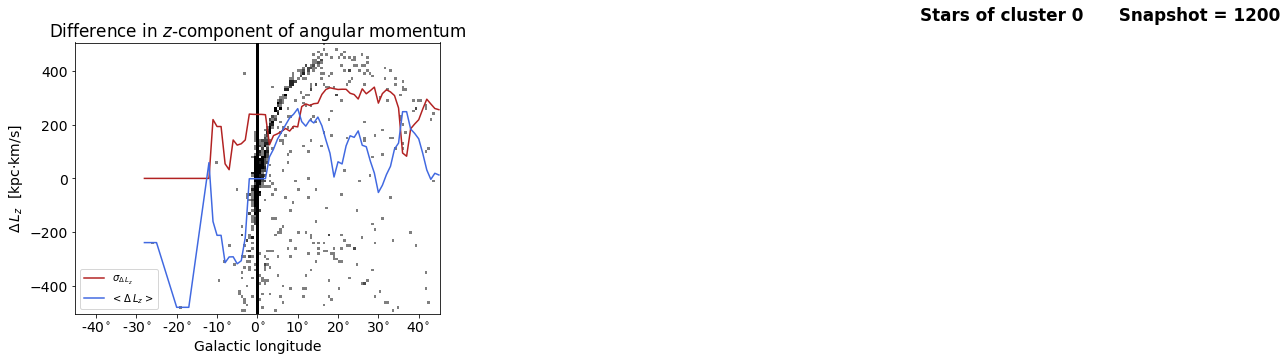

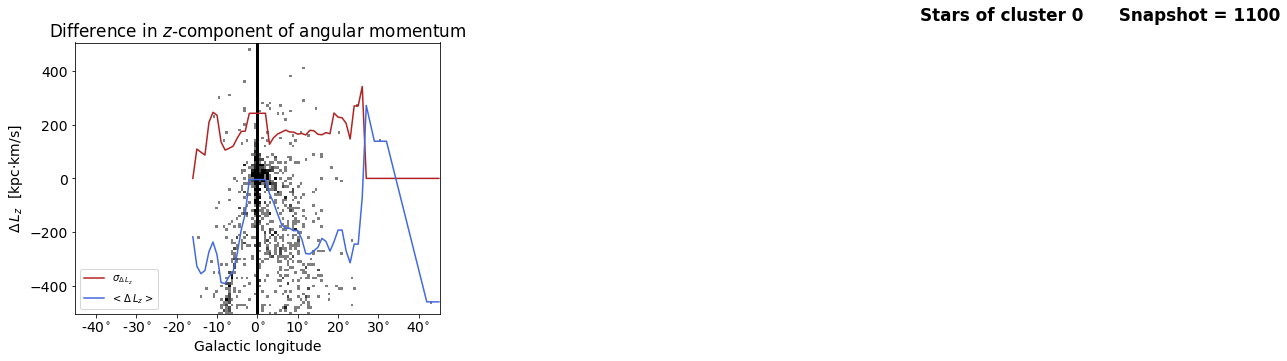

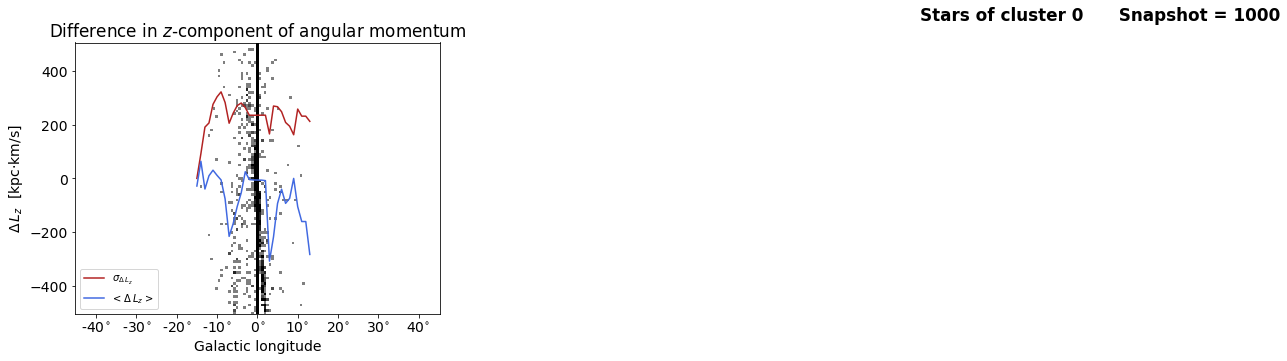

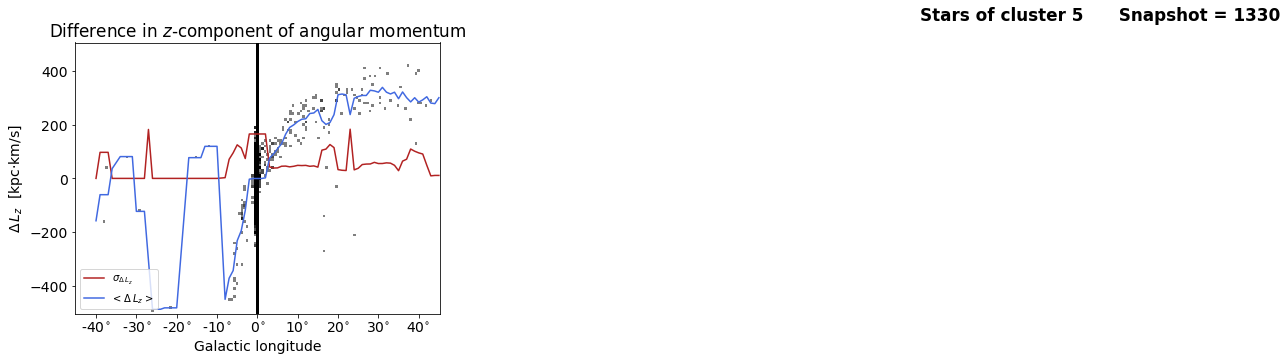

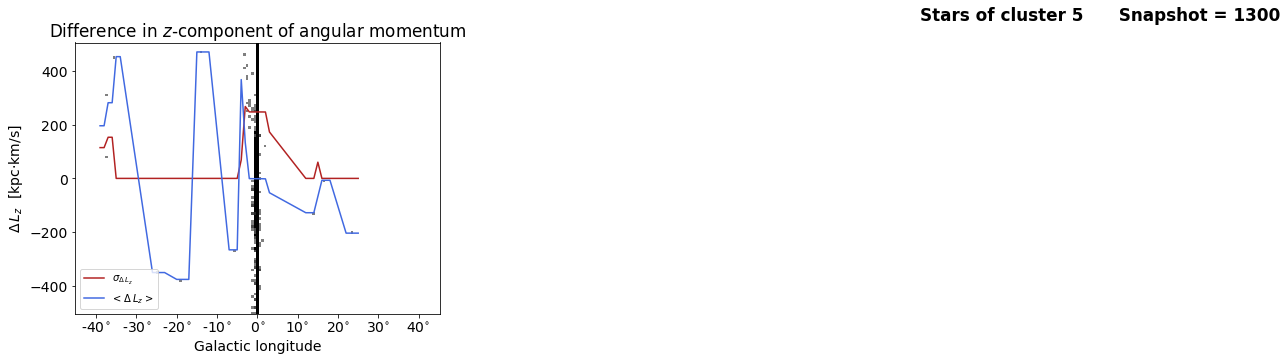

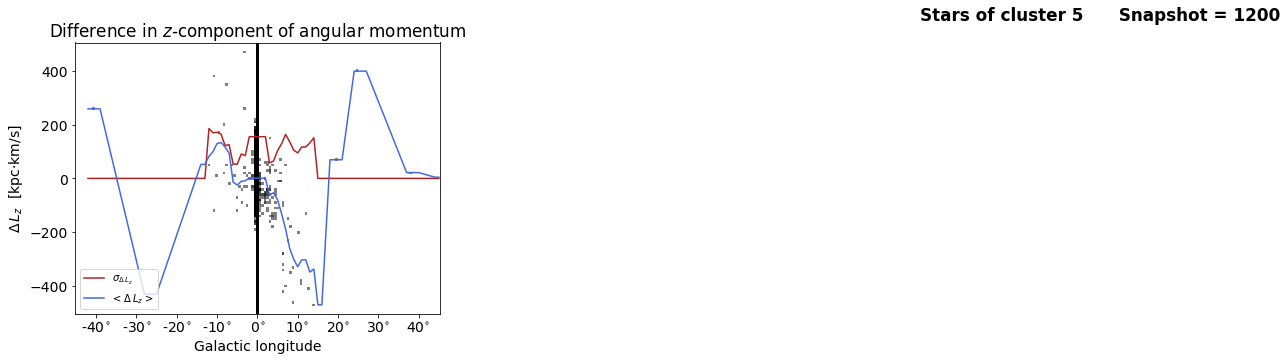

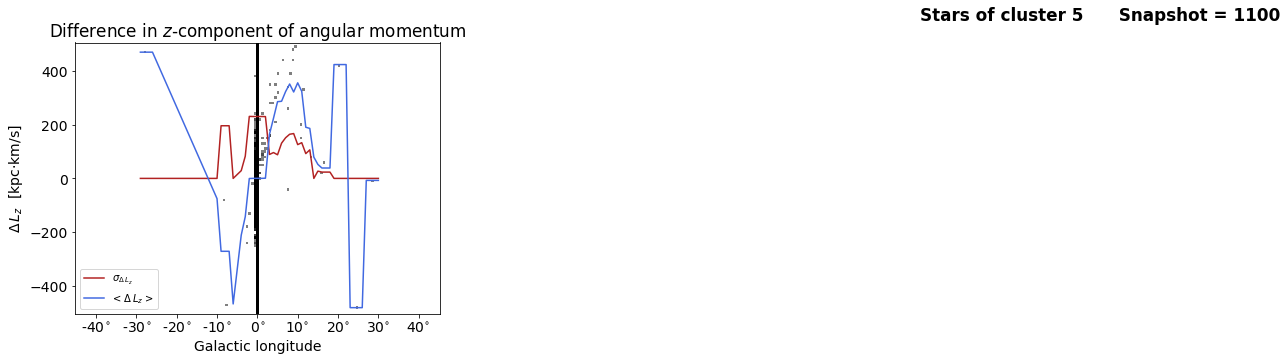

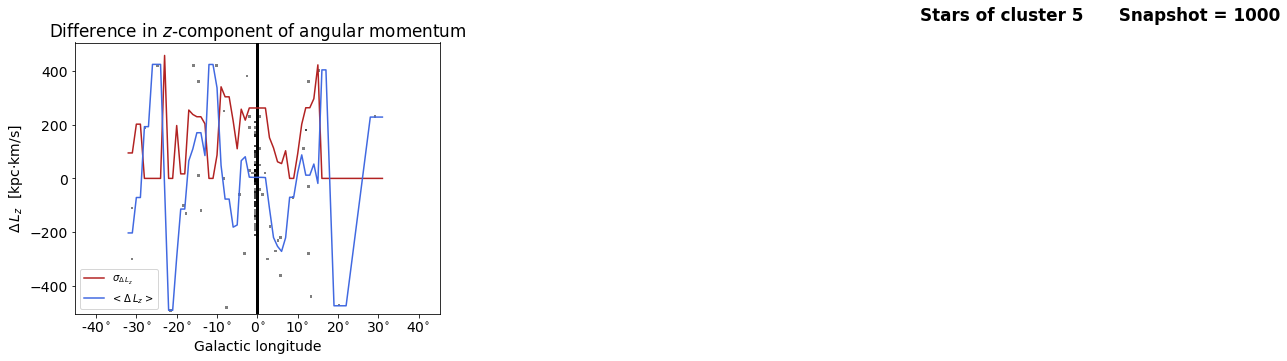

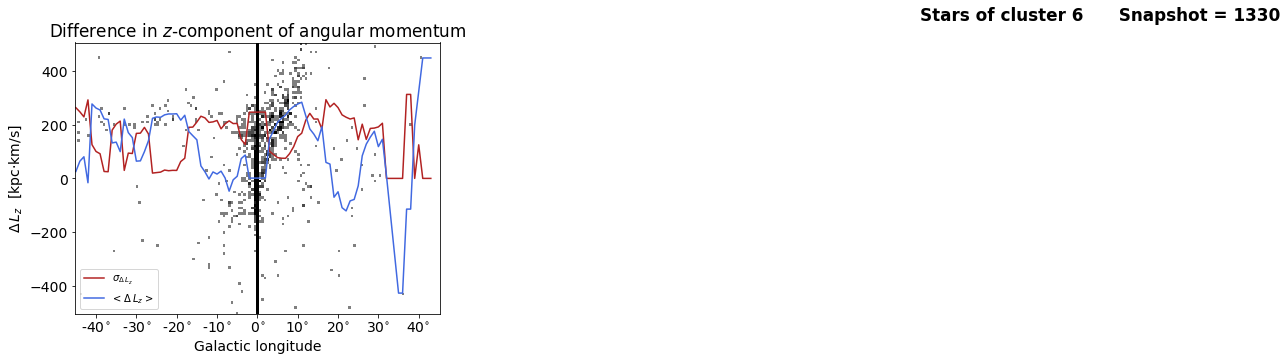

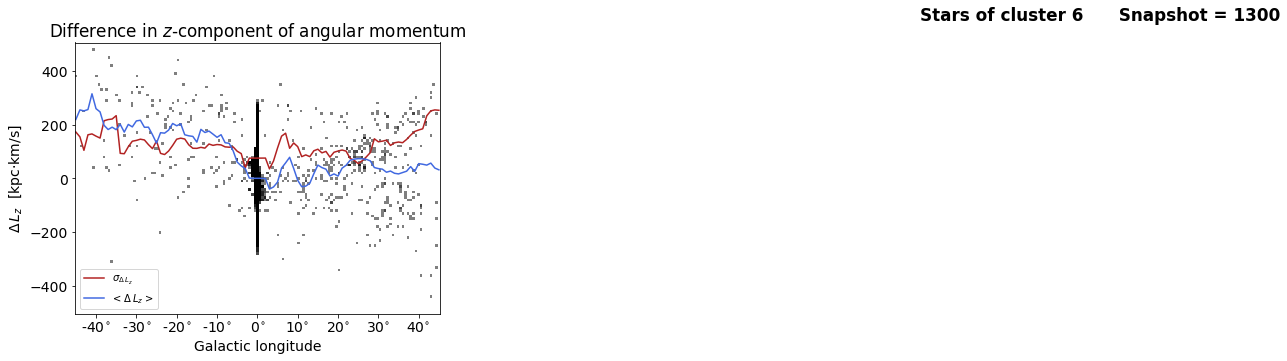

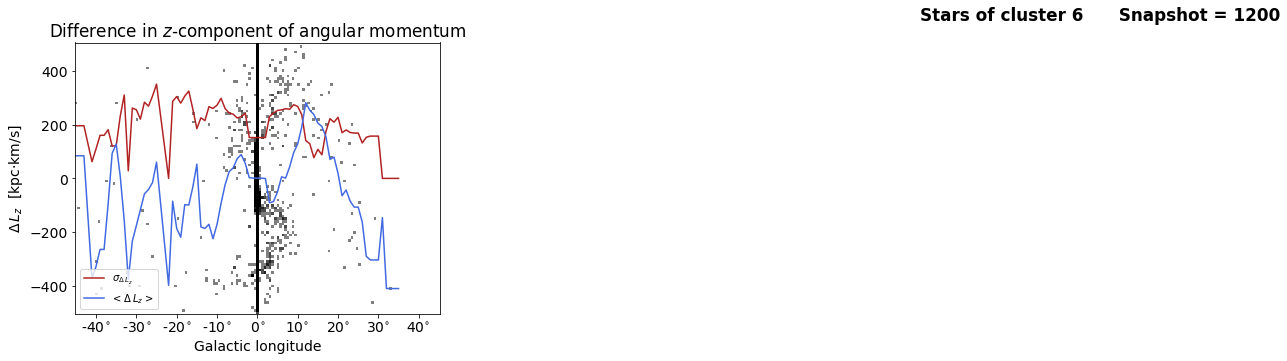

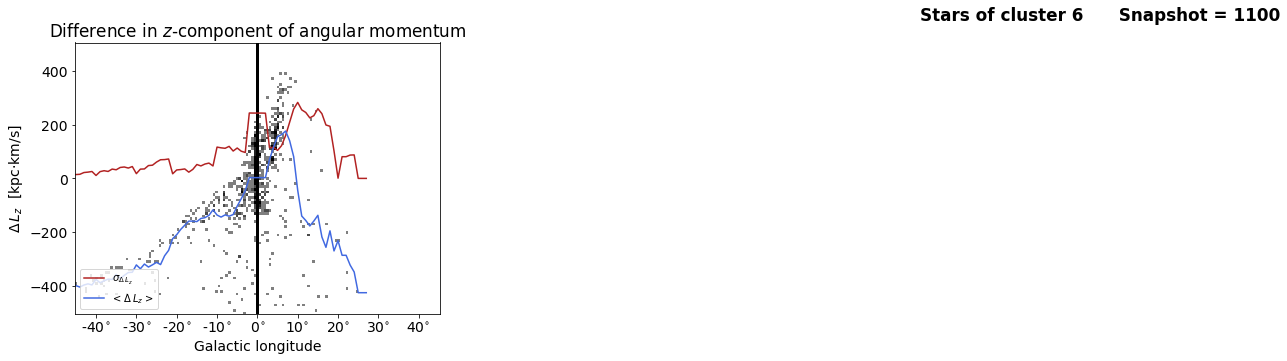

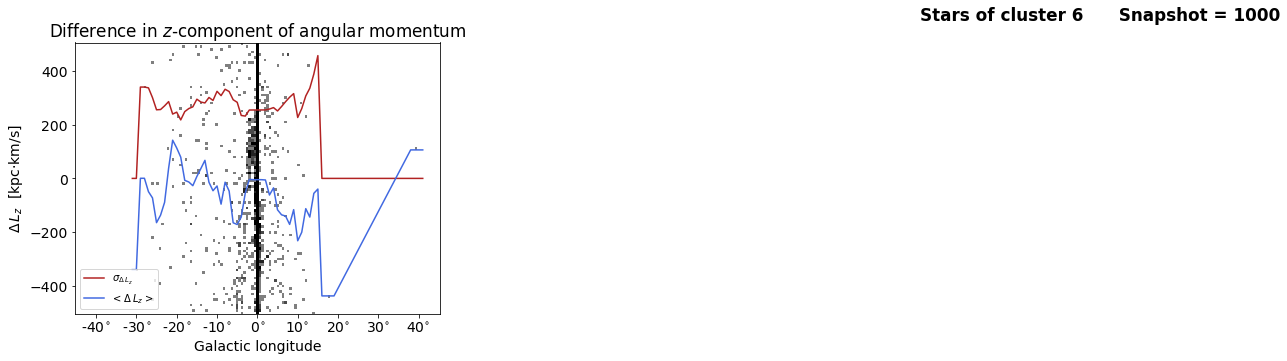

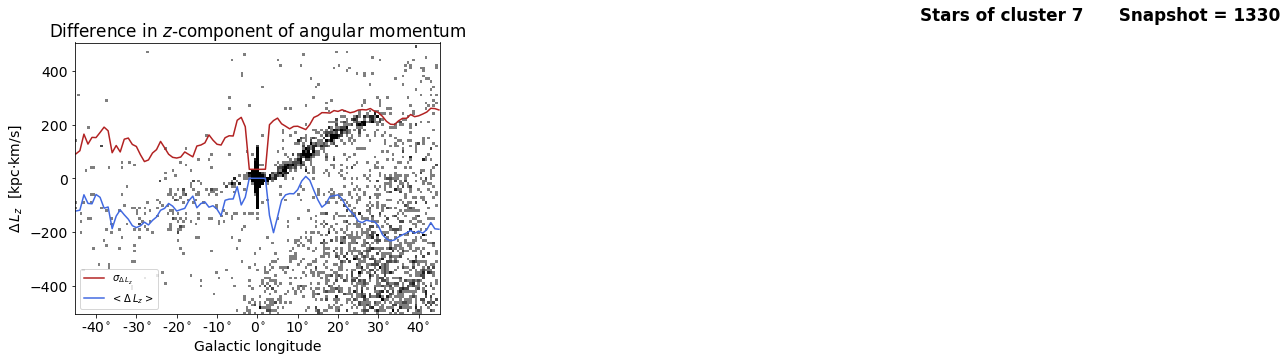

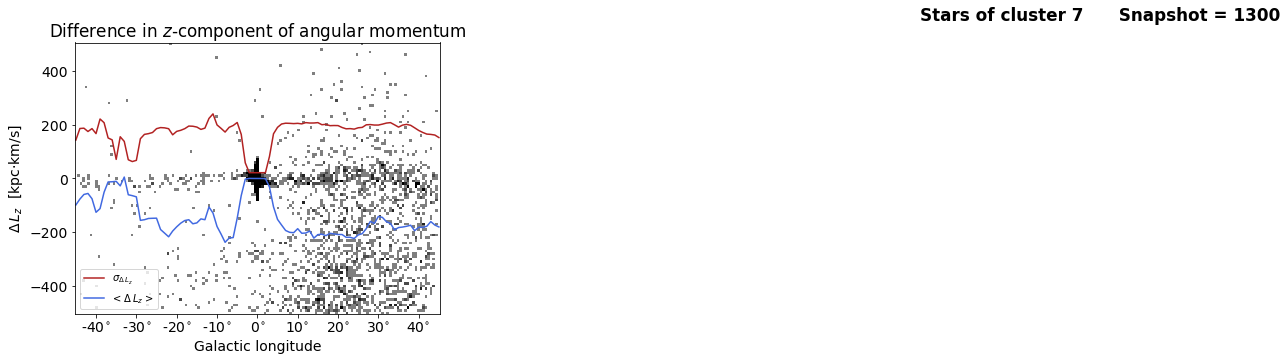

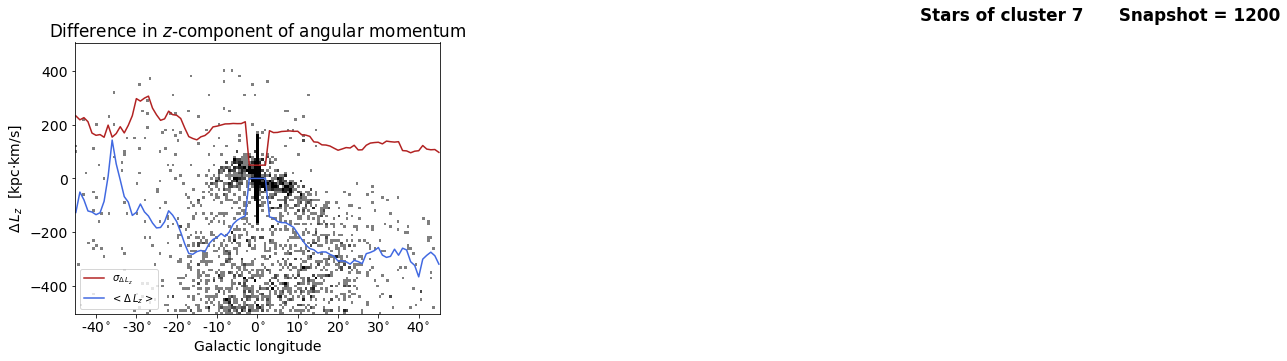

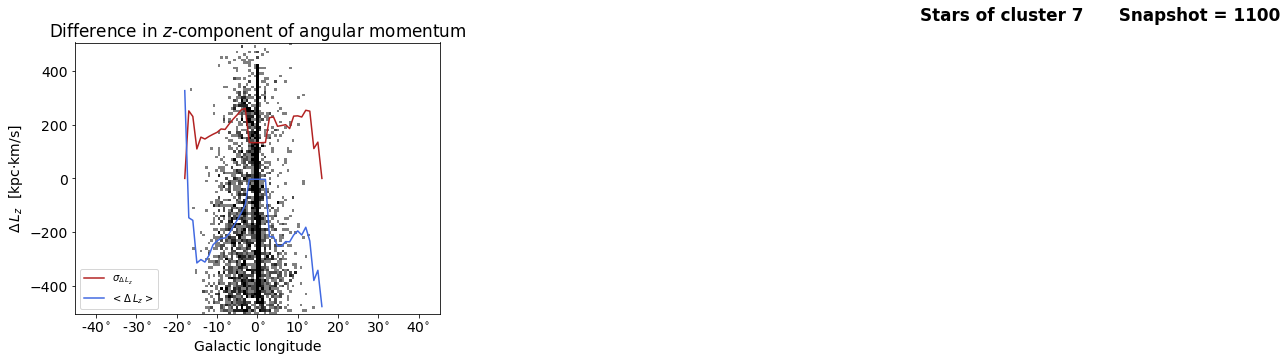

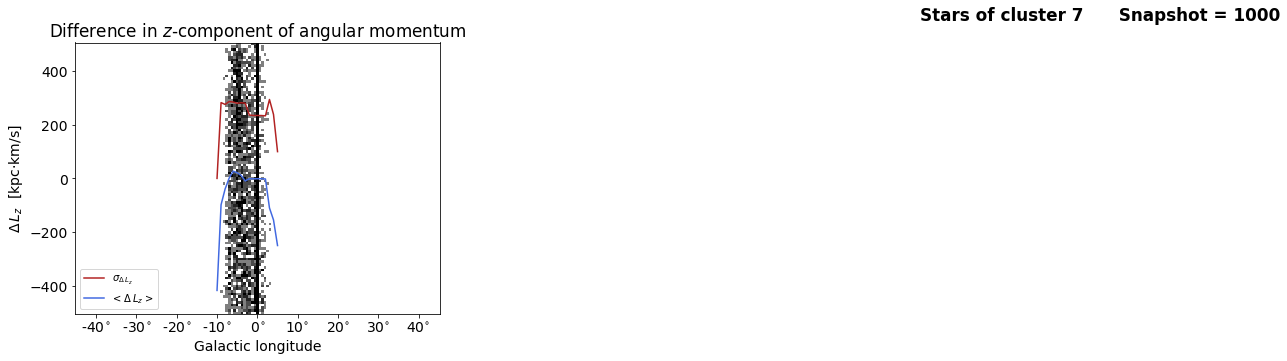

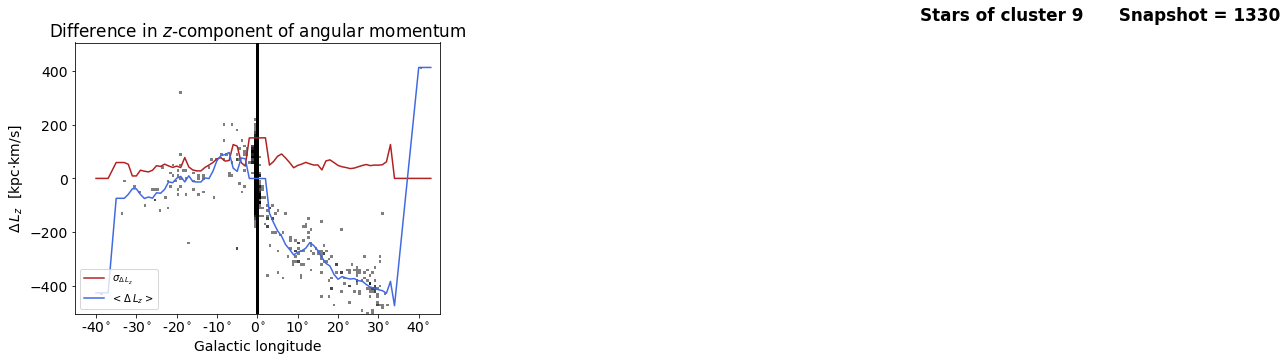

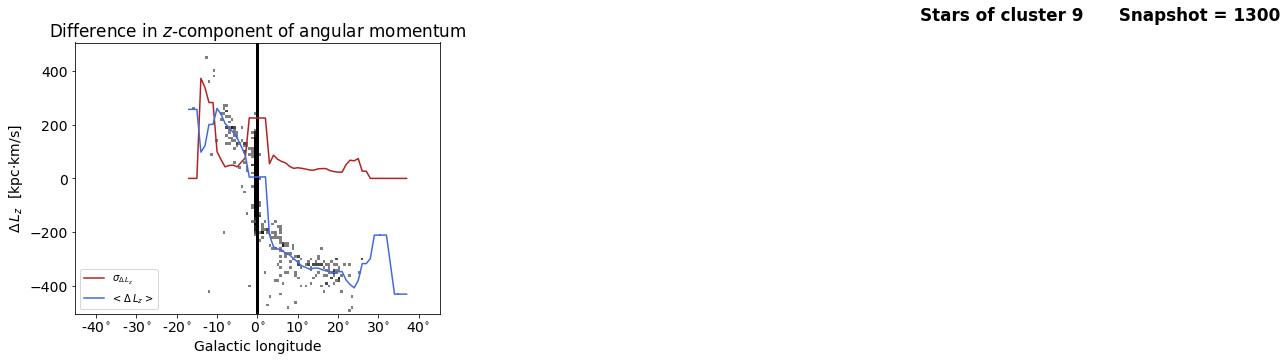

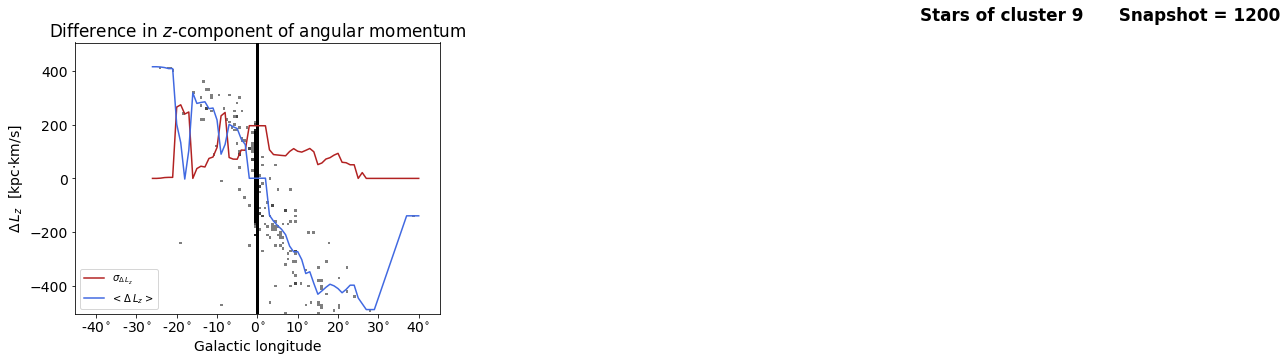

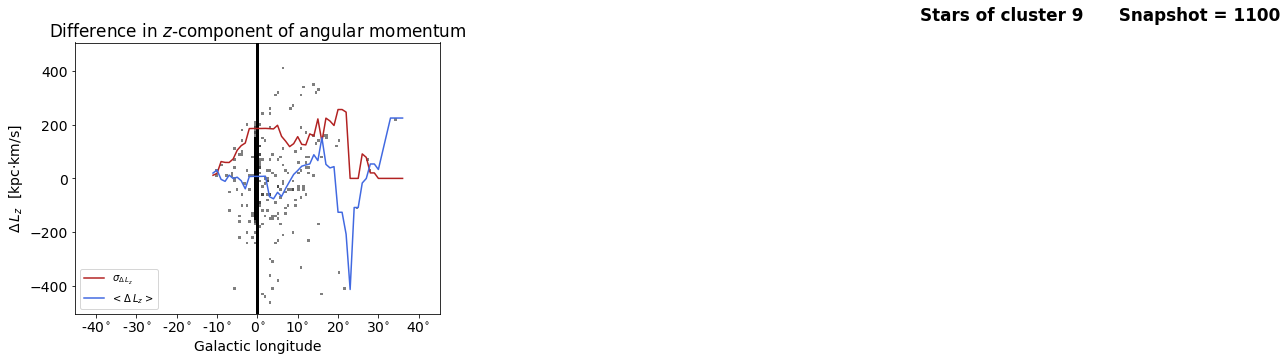

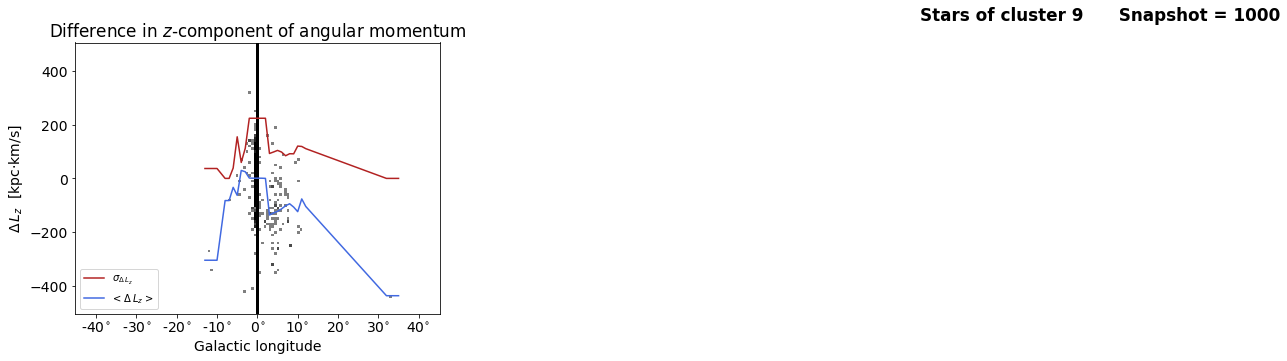

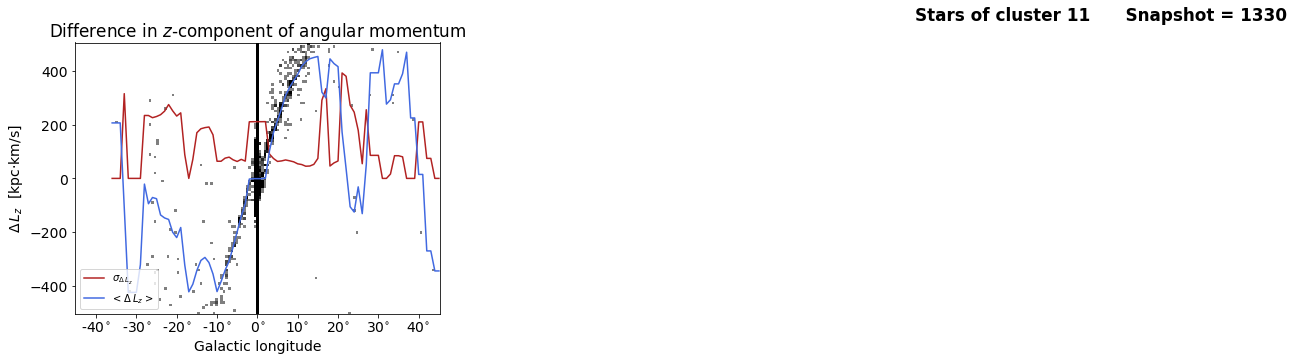

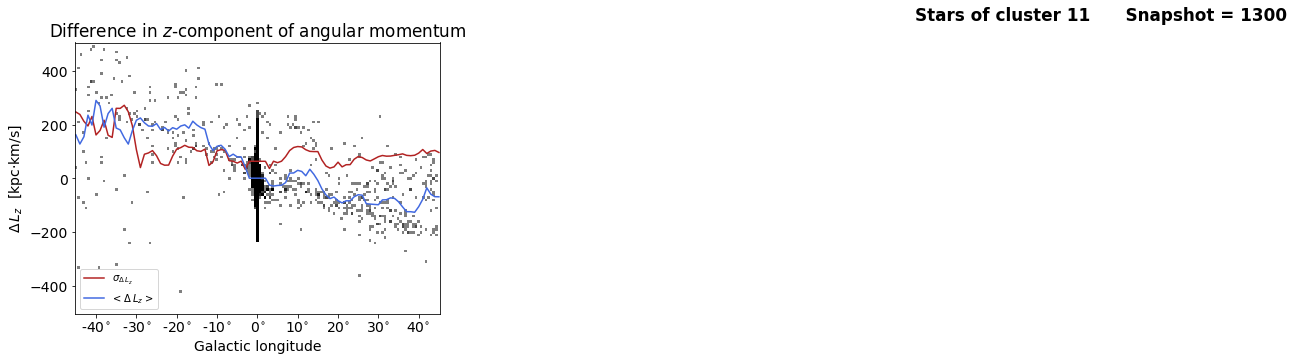

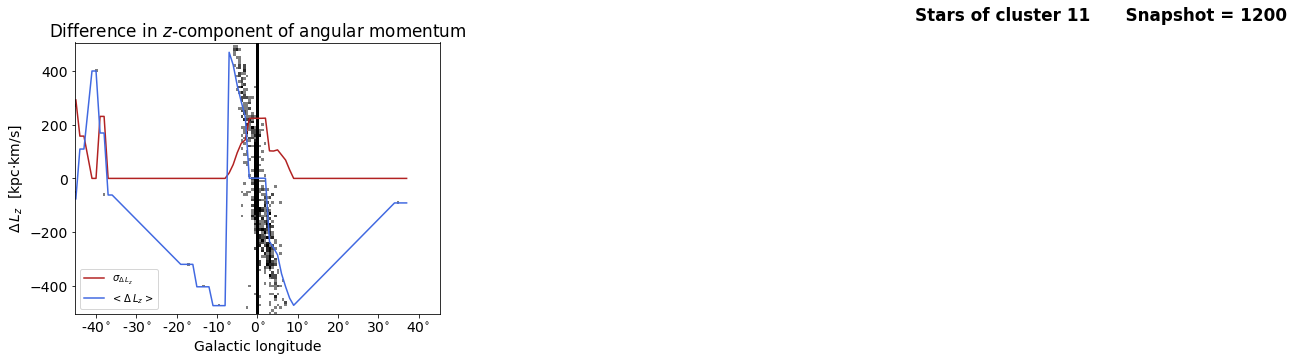

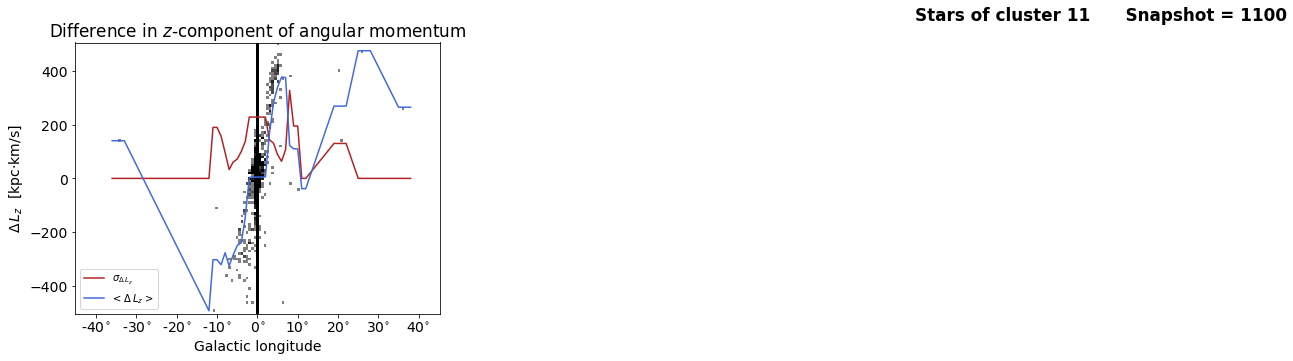

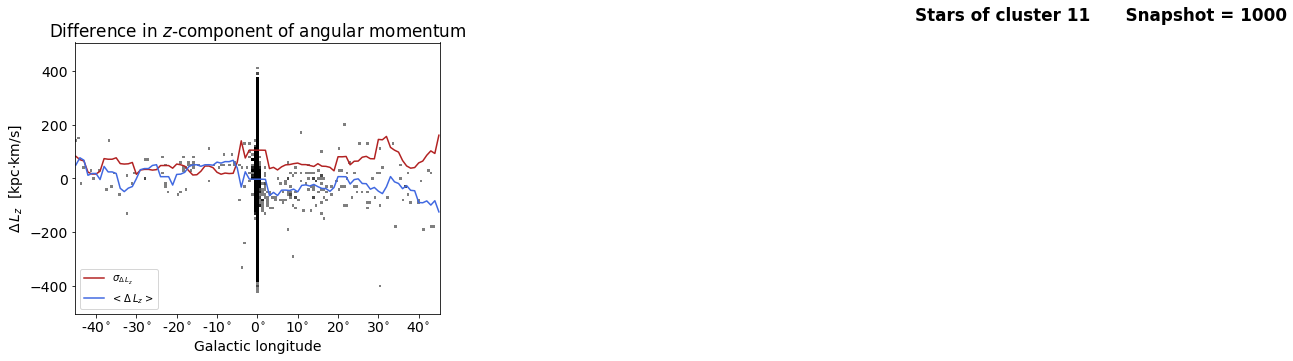

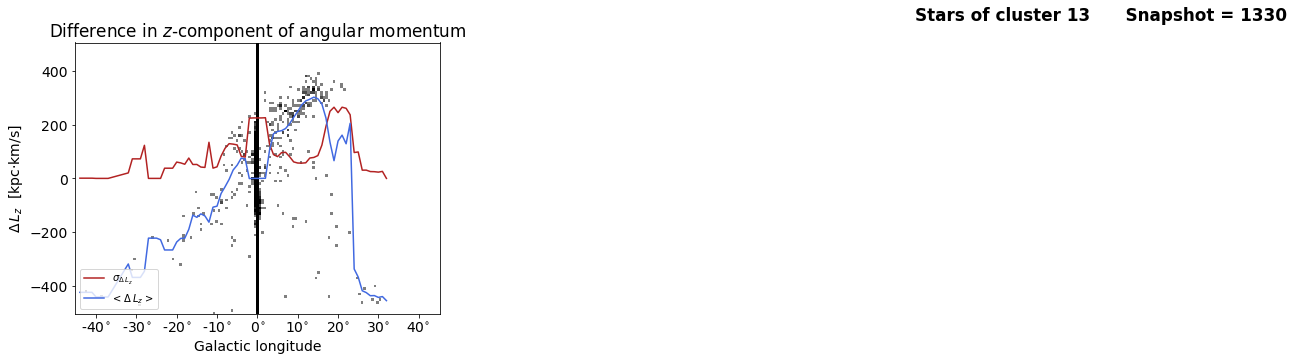

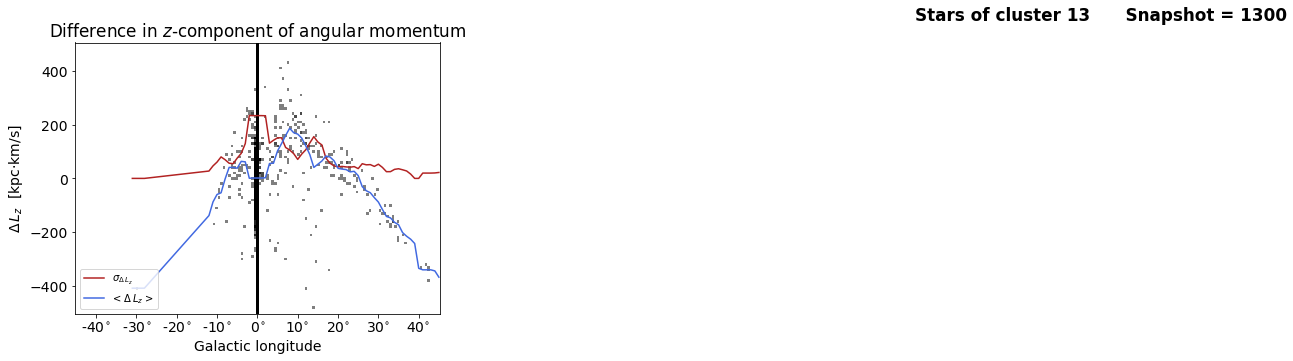

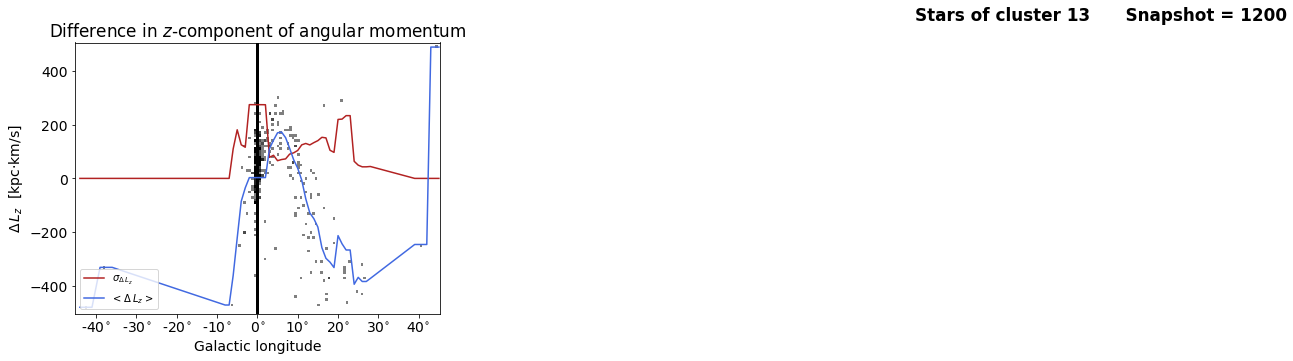

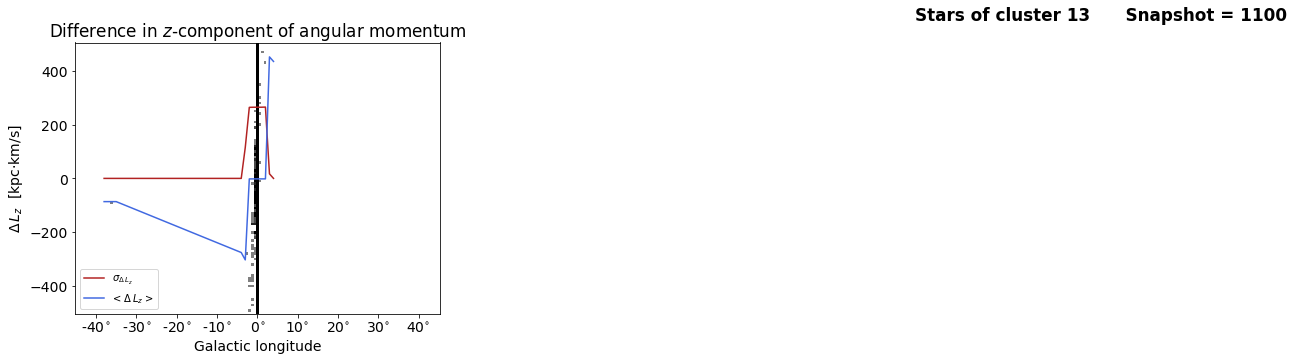

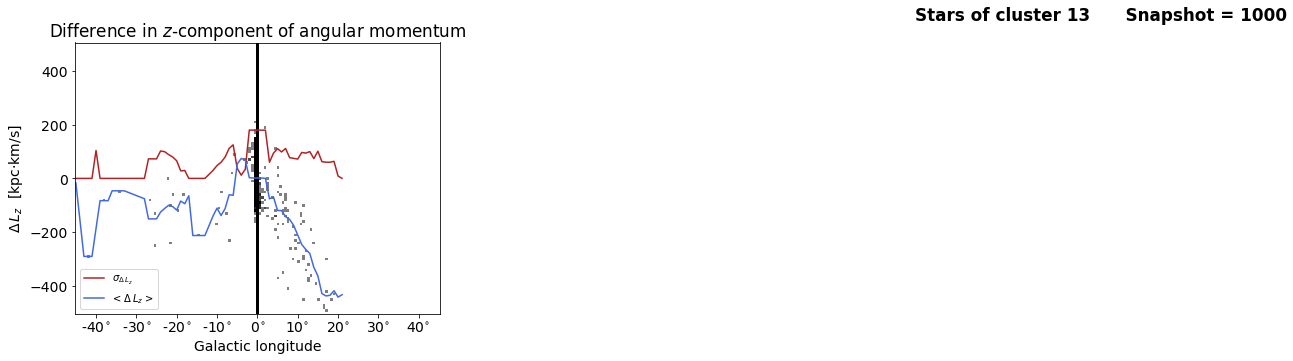

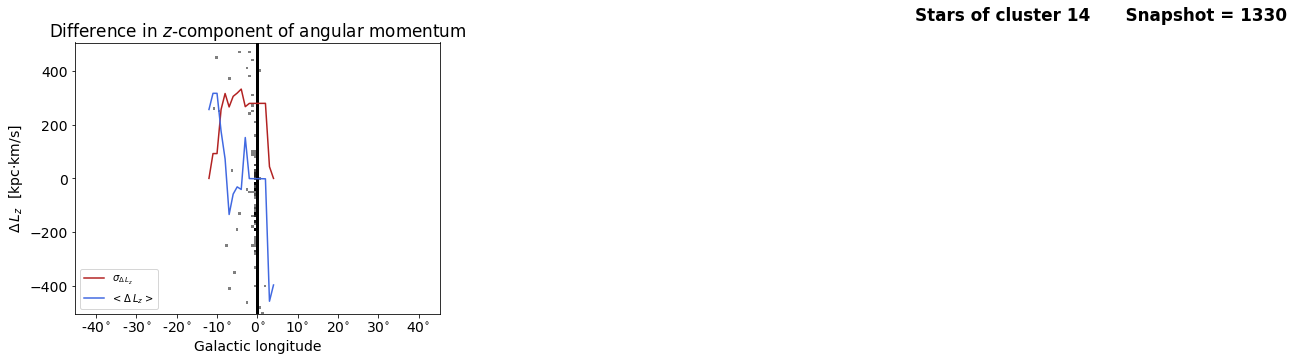

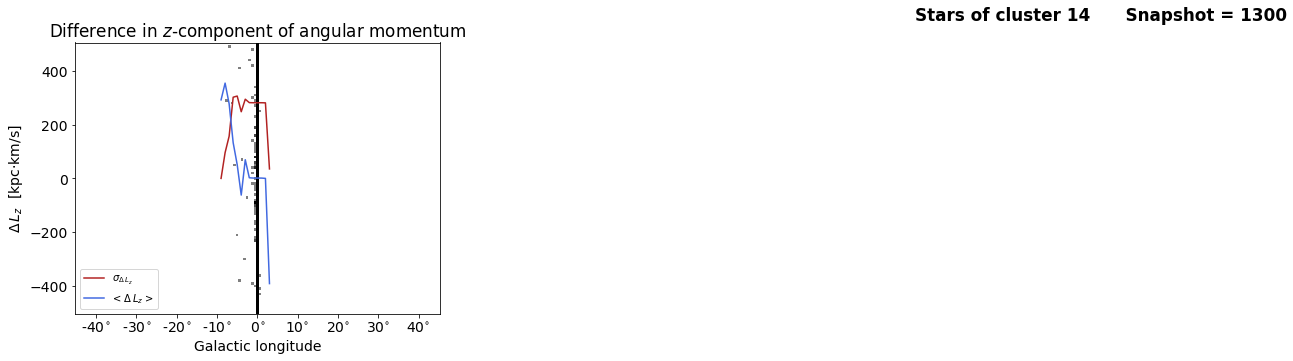

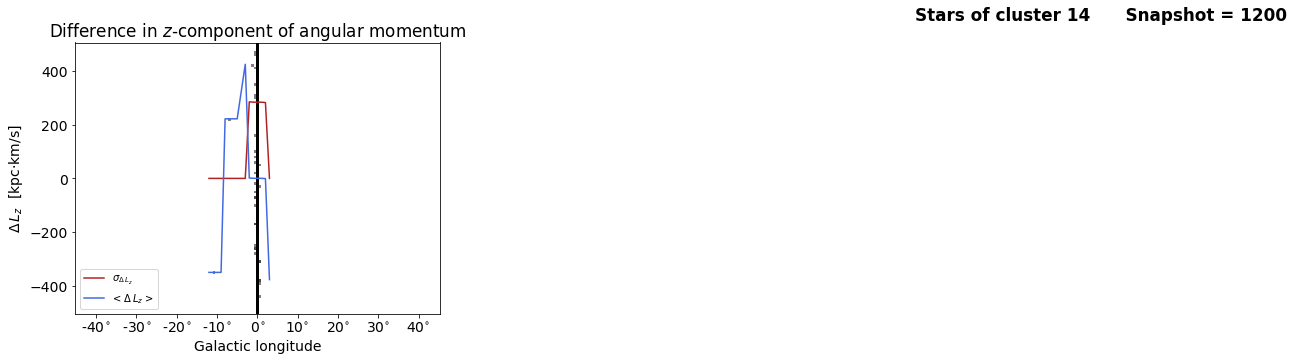

KeyboardInterrupt: 

<Figure size 2736x360 with 0 Axes>

In [14]:
for cluster in with_tail:
    
    for t in sorted(d.keys(), reverse=True):
    
        select = (d[t]['ics'] == cluster)

        cluster_x = d[t]['xc'][cluster]
        cluster_y = d[t]['yc'][cluster]
        cluster_z = d[t]['zc'][cluster]
        cluster_r = np.array([cluster_x, cluster_y, cluster_z])

        cluster_vx = d[t]['vxc'][cluster]
        cluster_vy = d[t]['vyc'][cluster]
        cluster_vz = d[t]['vzc'][cluster]
        cluster_v = np.array([cluster_vx, cluster_vy, cluster_vz])

        cluster_L = np.cross(cluster_r, cluster_v)

        transform = build_triple_rotation_matrix(ref_r=cluster_r, ref_L=cluster_L)

        new_cluster_r = transform @ cluster_r
        new_cluster_L = transform @ cluster_L

        new_cluster_Lx = new_cluster_L[0]
        new_cluster_Ly = new_cluster_L[1]
        new_cluster_Lz = new_cluster_L[2]

        ####
        stars_d = d[t]['ds'][select]
        ####

        stars_x = d[t]['xs'][select]
        stars_y = d[t]['ys'][select]
        stars_z = d[t]['zs'][select]

        stars_vx = d[t]['vxs'][select]
        stars_vy = d[t]['vys'][select]
        stars_vz = d[t]['vzs'][select]

        new_stars_Lx = []
        new_stars_Ly = []
        new_stars_Lz = []

        new_stars_x = []
        new_stars_y = []
        new_stars_z = []

        for i in range(len(stars_x)):

            star_x = stars_x[i]
            star_y = stars_y[i]
            star_z = stars_z[i]
            star_r = [star_x, star_y, star_z]

            star_vx = stars_vx[i]
            star_vy = stars_vy[i]
            star_vz = stars_vz[i]
            star_v = [star_vx, star_vy, star_vz]

            star_L = np.cross(star_r, star_v)
            new_star_L = transform @ star_L

            new_stars_Lx.append(new_star_L[0])
            new_stars_Ly.append(new_star_L[1])
            new_stars_Lz.append(new_star_L[2])

            new_star_r = transform @ star_r

            new_stars_x.append(new_star_r[0])
            new_stars_y.append(new_star_r[1])
            new_stars_z.append(new_star_r[2])

        new_stars_Lx = np.array(new_stars_Lx)
        new_stars_Ly = np.array(new_stars_Ly)
        new_stars_Lz = np.array(new_stars_Lz)

        new_stars_x = np.array(new_stars_x)
        new_stars_y = np.array(new_stars_y)
        new_stars_z = np.array(new_stars_z)

        new_stars_delta_Lx = new_stars_Lx - new_cluster_Lx
        new_stars_delta_Ly = new_stars_Ly - new_cluster_Ly
        new_stars_delta_Lz = new_stars_Lz - new_cluster_Lz

        new_stars_L_perp = np.sqrt((new_stars_delta_Lx) ** 2 + (new_stars_delta_Ly) ** 2)

        new_stars_rho = np.sqrt(new_stars_x ** 2 + new_stars_y ** 2 + new_stars_z ** 2)

        # longs and lats formulae taken from previous notebook
        stars_longitudes = np.arctan2(new_stars_y, new_stars_x)
        stars_latitudes = np.arcsin(new_stars_z / new_stars_rho)


        plt.figure(figsize=(38, 5))
        plt.rc('font', size=14)


#         lon_v, lat_v = np.meshgrid(lon, lat)

#         D = np.zeros((ng_lat + 1, ng_lon + 1))

#         for star in range(len(stars_longitudes)):

#             if (-lon_max <= stars_longitudes[star] <= lon_max) and (-lat_max <= stars_latitudes[star] <= lat_max):

#                 ix = int(round((stars_longitudes[star] + lon_max) / dg)) 
#                 iy = int(round((stars_latitudes[star] + lat_max) / dg)) 
#                 D[iy, ix] += 1

#         Ds = np.sqrt(D)

#         plt.subplot(1,5,1)
#         plt.pcolormesh(lon_v, lat_v, Ds, cmap='binary', vmin=1, vmax=2)
#         plt.scatter(stars_longitudes, stars_latitudes, s=8, c='orangered', alpha=0.12)

#         plt.xlim(-lon_max, lon_max)
#         plt.ylim(-17 * u.deg.to(u.rad), 17 * u.deg.to(u.rad))

#         plt.xticks(ticks=lon_range_deg * u.deg.to(u.rad), labels=lon_range_deg_str)
#         plt.yticks(ticks=lat_range_deg * u.deg.to(u.rad), labels=lat_range_deg_str)

#         plt.xlabel('Galactic longitude')
#         plt.ylabel('Galactic latitude')
#         plt.title('Position in galactocentric coordinates')


#         ###
#         #d_max = max(stars_d) #/ zoom
#         d_max = 100
#         d_min = 0
#         ng_d = int((d_max - d_min) * 1 + 1)

#         d_linspace = np.linspace(d_min, d_max, ng_d + 1) 
#         lon_v, d_v = np.meshgrid(lon, d_linspace)

#         D = np.zeros((ng_d + 1, ng_lon + 1))

#         for star in range(len(stars_longitudes)):

#             if (-lon_max <= stars_longitudes[star] <= lon_max) \
#         and (d_min <= stars_d[star] <= d_max):

#                 ix = int(round((stars_longitudes[star] + lon_max) / dg)) 
#                 iy = int(round((stars_d[star] + -d_min) * 1)) 

#                 D[iy, ix] += 1

#         Ds = np.sqrt(D)
#         ###

#         plt.subplot(1,5,2)
#         plt.pcolormesh(lon_v, d_v, Ds, cmap='binary', vmin=1, vmax=2)

#         plt.xticks(ticks=lon_range_deg * u.deg.to(u.rad), labels=lon_range_deg_str)

#         plt.xlabel('Galactic longitude')
#         plt.ylabel('Distance  [kpc]')
#         plt.title('Distance from galactic centre')


#         ###
#         #L_x_max = max(new_stars_delta_Lx) / zoom
#         #L_x_min = min(new_stars_delta_Lx) / zoom
        
#         L_x_max = 500
#         L_x_min = -500
#         #ng_L_x = int((L_x_max - L_x_min) / 10 + 1)
#         ng_L_x = 100

#         L_x_linspace = np.linspace(L_x_min, L_x_max, ng_L_x + 1) 
#         lon_v, L_x_v = np.meshgrid(lon, L_x_linspace)

#         D = np.zeros((ng_L_x + 1, ng_lon + 1))

#         for star in range(len(stars_longitudes)):

#             if (-lon_max <= stars_longitudes[star] <= lon_max) \
#         and (L_x_min <= new_stars_delta_Lx[star] <= L_x_max):

#                 ix = int(round((stars_longitudes[star] + lon_max) / dg)) 
#                 iy = int(round((new_stars_delta_Lx[star] + -L_x_min) / 10)) 

#                 D[iy, ix] += 1

#         Ds = np.sqrt(D)
#         ###

#         plt.subplot(1,5,3)
#         plt.pcolormesh(lon_v, L_x_v, Ds, cmap='binary', vmin=0, vmax=2)

#         plt.xticks(ticks=lon_range_deg * u.deg.to(u.rad), labels=lon_range_deg_str)

#         plt.xlabel('Galactic longitude')
#         plt.ylabel(r'$\Delta \, L_x$  [kpc$\cdot$km/s]')
#         plt.title(r'Difference in $x$-component of angular momentum')


#         ###
# #         L_y_max = max(new_stars_delta_Ly) / zoom
# #         L_y_min = min(new_stars_delta_Ly) / zoom
# #         ng_L_y = int((L_y_max - L_y_min) / 10 + 1)
        
#         L_y_max = 500
#         L_y_min = -500
#         ng_L_y = 100

#         L_y_linspace = np.linspace(L_y_min, L_y_max, ng_L_y + 1) 
#         lon_v, L_y_v = np.meshgrid(lon, L_y_linspace)

#         D = np.zeros((ng_L_y + 1, ng_lon + 1))

#         for star in range(len(stars_longitudes)):

#             if (-lon_max <= stars_longitudes[star] <= lon_max) and (L_y_min <= new_stars_delta_Ly[star] <= L_y_max):

#                 ix = int(round((stars_longitudes[star] + lon_max) / dg)) 
#                 iy = int(round((new_stars_delta_Ly[star] + -L_y_min) / 10)) 

#                 D[iy, ix] += 1

#         Ds = np.sqrt(D)
#         ###    

#         plt.subplot(1,5,4)
#         plt.pcolormesh(lon_v, L_y_v, Ds, cmap='binary', vmin=0, vmax=2)

#         plt.xticks(ticks=lon_range_deg * u.deg.to(u.rad), labels=lon_range_deg_str)

#         plt.xlabel('Galactic longitude')
#         plt.ylabel(r'$\Delta \, L_y$  [kpc$\cdot$km/s]')
#         plt.title(r'Difference in $y$-component of angular momentum')

        ###
#         L_z_max = max(new_stars_delta_Lz) / zoom
#         L_z_min = min(new_stars_delta_Lz) / zoom
#         ng_L_z = int((L_z_max - L_z_min) / 10 + 1)

        L_z_max = 500
        L_z_min = -500
        ng_L_z = 100

        L_z_linspace = np.linspace(L_z_min, L_z_max, ng_L_z + 1) 
        lon_v, L_z_v = np.meshgrid(lon, L_z_linspace)

        D = np.zeros((ng_L_z + 1, ng_lon + 1))

        for star in range(len(stars_longitudes)):

            if (-lon_max <= stars_longitudes[star] <= lon_max) \
        and (L_z_min <= new_stars_delta_Lz[star] <= L_z_max):

                ix = int(round((stars_longitudes[star] + lon_max) / dg)) 
                iy = int(round((new_stars_delta_Lz[star] + -L_z_min) / 10)) 

                D[iy, ix] += 1

        Ds = np.sqrt(D)
        ###
        
        (degs, avg_delta_Lz, std_delta_Lz) = n_sigma_clipping(max_longitude_rad=lon_max, 
                                                              longitudes_rad=stars_longitudes, 
                                                              values=new_stars_delta_Lz,
                                                              w=2, max_value=L_z_max, min_value=L_z_min, n=2.5)

        plt.subplot(1,5,1)
#         plt.subplot(1,5,5)
        plt.pcolormesh(lon_v, L_z_v, Ds, cmap='binary', vmin=0, vmax=2)
        plt.plot(degs * u.deg.to(u.rad), std_delta_Lz, '-', color='firebrick',
                label=r'$\sigma_{\Delta \, L_z}$')
        plt.plot(degs * u.deg.to(u.rad), avg_delta_Lz, '-', color='royalblue', 
                label=r'< $\Delta \, L_z$ >')

        plt.xticks(ticks=lon_range_deg * u.deg.to(u.rad), labels=lon_range_deg_str)

        plt.xlabel('Galactic longitude')
        plt.ylabel(r'$\Delta \, L_z$  [kpc$\cdot$km/s]')
        plt.legend(loc='lower left', fontsize=10)
        plt.title(r'Difference in $z$-component of angular momentum')


        plt.suptitle('Stars of cluster ' + str(cluster) + ' ' * 6 + 'Snapshot = ' + t, fontweight='bold')
        plt.show()
        
    print('\n\n')